# Basic example of latticeproteins

In [ ]:
import latticeproteins as lp # envt is latticeproteins
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom
from helpers import DotAccessibleDict
from IPython.display import SVG, HTML
import multiprocessing

!pwd

In [ ]:
seq_length = 12
lattice = lp.thermodynamics.LatticeThermodynamics.from_length(seq_length, 1.0)
conf = None
while conf is None:
    seq = lp.random_sequence(seq_length)
    conf = lattice.native_conf(seq)
print("".join(seq), conf)

print("Energy of native conformation: %f" % lattice.nativeE(seq, target=conf))
print("stability of native conformation: %f" % lattice.stability(seq, target=conf))
print("fraction folded: %f" % lattice.fracfolded(seq, target=conf))
display(lp.draw.in_notebook(seq, conf).notebook)

In [ ]:
lig_length = 6
lig_lattice = lp.thermodynamics.LatticeThermodynamics.from_length(lig_length, 1.0)

lig_conf = None
while lig_conf is None:
    lig_seq = lp.random_sequence(lig_length)
    lig_conf = lig_lattice.native_conf(lig_seq)
print(f"Ligand: seq={''.join(lig_seq)} conf={lig_conf}")
print("Energy of native conformation: %f" % lig_lattice.nativeE(lig_seq, target=lig_conf))
print("stability of native conformation: %f" % lig_lattice.stability(lig_seq, target=lig_conf))
print("fraction folded: %f" % lig_lattice.fracfolded(lig_seq, target=lig_conf))
display(lp.draw.in_notebook([x.lower() for x in lig_seq], lig_conf, color_sequence="r"*lig_length))

In [ ]:
# bind the ligand to the protein

(be, xshift, yshift, lig_conf) = lp.conformations.BindLigand(seq, conf, lig_seq, lig_conf)
ligand_tup = (lig_seq, None, lig_conf, xshift, yshift) # the None is for ligand_color_seq
print(f"be: {be:0.3f}, xshift: {xshift}, yshift: {yshift}")


# save to .txt file
with open("bound_ligand.txt", "w", encoding="utf-8") as f:
    lp.conformations.PrintConformation(seq, conf, file = f, latex_format = False, ligand_tup = ligand_tup)

# save to .svg file
lp.draw.to_file(seq, conf, "bound_ligand.svg", ligand_tup=ligand_tup)

# display in notebook
lp.draw.in_notebook(seq, conf, ligand_tup=ligand_tup)

---
---

args: {'seq_length': 18, 'lig_length': 6, 'minFoldFrac': 0.9, 'N': 16384, 'clades': 4, 'mu': 0.0005, 'softFit': 0.5, 'maxGen': 25, 'logscale': True} 


=== Generation 24 ===

=== Generation 24 ===


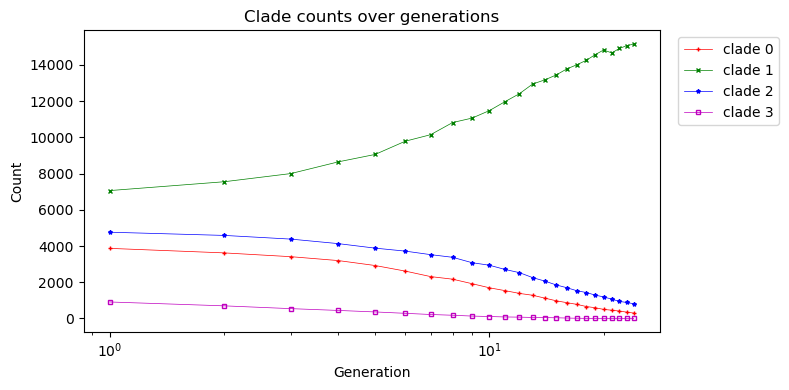

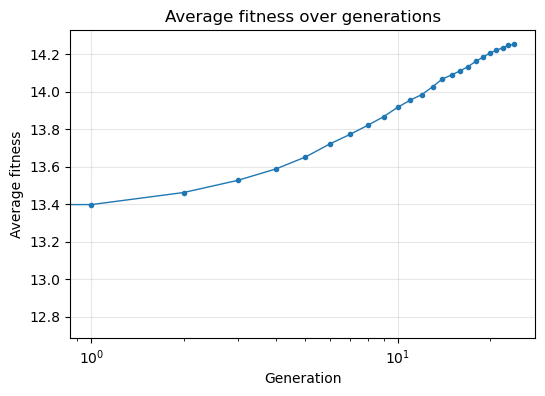

In [ ]:
import multiprocessing as mp

# evolution!
 
seq_length = None
lig_length = None

def plot_prot_stats(args, prots):
    count_no_native = 0
    Elist, Slist, FoldFracList, Blist, FitList = [], [], [], [], []
    for prot in prots:
        seq = prot.seq
        conf = lattice.native_conf(seq)
    
        if conf is not None:
            (E, S, FF, be, fit) = get_fitness_etc(lattice, seq, conf, lig_seq, lig_conf)
            Elist.append(E)
            Slist.append(S)
            FoldFracList.append(FF)
            Blist.append(be)
            FitList.append(fit)
        else:
            print("No unique native conformation for seq:", seq)
            count_no_native += 1
            FitList.append(0.0)

    print(f"Number of sequences with no unique native conformation: {count_no_native}")

    # plot histogram of each
    # plt.hist(Elist, bins=20)
    # plt.xlabel("Native Energy")
    # plt.ylabel("Count")
    # plt.show()

    # plt.hist(Slist, bins=20)
    # plt.xlabel("Stability")
    # plt.ylabel("Count")
    # plt.show()

    # plt.hist(FoldFracList, bins=20)
    # plt.xlabel("Fraction Folded")
    # plt.ylabel("Count")
    # plt.show()

    # plt.hist(Blist, bins=20)
    # plt.xlabel("Binding Energy")
    # plt.ylabel("Count")
    # plt.show()

    plt.hist(FitList, bins=20)
    plt.xlabel("Fitness (BE * FF)")
    plt.ylabel("Count")
    plt.show()
    
    # cladeList = [prot.clade_idx for prot in prots]
    # plt.hist(cladeList, bins=range(args.clades+1))
    # plt.xlabel("Clade Index")
    # plt.ylabel("Count")
    # plt.show()

def get_fitness_etc(lattice, seq, conf, lig_seq, lig_conf):
    assert conf is not None
    
    E = lattice.nativeE(seq, target=conf)
    S = lattice.stability(seq, target=conf)
    FF = lattice.fracfolded(seq, target=conf)
    (be, xshift, yshift, newconf) = lp.conformations.BindLigand(seq, conf, lig_seq, lig_conf)
    fit = - be * FF

    return (E, S, FF, be, fit)

# set up initial population from clones of founders
def make_clones(args, founders):
    prots = []
    copies = args.N // args.clades
    #print(f"Making {copies} copies of each of {args.clades} founders")
    for i, founder in enumerate(founders):
        for _ in range(copies):
            prot = Prot(args, clade_idx=founder.clade_idx, parent_idx=None, seq=founder.seq)
            prot.compute_fitness(lig_seq, lig_conf)
            prots.append(prot)
    return prots

class Prot():
    global_idx = 0 # class variable to give each Prot a unique index

    def __init__(self, args, clade_idx, parent_idx, seq=None):
        self.args = args
        self.seq_length = args.seq_length
        if self.seq_length != self.args.lattice.conformations._length:
            raise ValueError(f"Prot seq_length {self.seq_length} does not match lattice length {lattice.confs._length}")
        if seq is None: # pick a random sequence
            conf = None
            while conf is None:
                # if args.minFoldFrac is not None: # require a minimum fraction folded
                #     f = 0.0
                #     while f <= args.minFoldFrac:
                #         seq = lp.random_sequence(args.seq_length)
                #         conf = lattice.native_conf(seq)
                #         f = lattice.fracfolded(seq, target=conf)
                # else: # just pick a random sequence, with a native fold
                #     seq = lp.random_sequence(args.seq_length)
                #     conf = lattice.native_conf(seq)

                # folds = False
                # while not folds:
                #     seq = lp.random_sequence(args.seq_length)
                #     (minE, conf, partitionsum, folds) = lattice._nativeE(seq)
                
                minE = 999
                while minE >= -1:
                    seq = lp.random_sequence(args.seq_length)
                    (minE, conf, partitionsum, folds) = self.args.lattice._nativeE(seq)
                
        else: # use the provided sequence
            (minE, conf, partitionsum, folds) = self.args.lattice._nativeE(seq)
            # if conf is None:
            #     print("Warning: created Prot with no unique native conformation for seq:", seq)

        self.seq = seq
        self.conf = conf # might be None if no unique native conf
        self.minE = minE
        self.fit = None
        self.clade_idx = clade_idx # index of the original founding ancestor Prot
        self.parent_idx = parent_idx # index of the immediate parent Prot. Founders have parent_idx = None
        
        # give each created Prot a unique index
        self.idx = Prot.global_idx
        Prot.global_idx += 1
        
    def __repr__(self):
        (E, S, FF, be, fit) = get_fitness_etc(self.args.lattice, self.seq, self.conf, lig_seq, lig_conf)
        str = ""
        str += f"  Prot({self.idx}: clade={self.clade_idx}, parent={self.parent_idx}, seq={''.join(self.seq)}, conf={self.conf}\n"
        str += f"  Energy:{E:.2f} Stability:{S:.2f} Fraction folded:{FF:.2f} Binding energy:{be:.2f} Fitness{fit:.2f}"
        return str

    def display(self):    
        display(lp.draw.in_notebook(self.seq, self.conf).notebook)
        
    def compute_fitness(self, lig_seq, lig_conf):
        if self.conf is None:
            fit = 0.0
        else:
            if True: # use Palmer 2013 fitness function
                (be, xshift, yshift, newconf) = lp.conformations.BindLigand(self.seq, self.conf, lig_seq, lig_conf)
                fit = np.exp(-be) # as in Palmer 2013
            else: # use Bloom 2004 fitness function
                FF = self.args.lattice.fracfolded(self.seq, target=self.conf)
                if FF == 0.0:
                    fit = 0.0
                else:
                    (be, xshift, yshift, newconf) = lp.conformations.BindLigand(self.seq, self.conf, lig_seq, lig_conf)
                    fit = max(0.0, - be * FF)  # as in Bloom 2004
                    #fit = np.exp(max(0.0, - be * FF)) # other
        self.fit = fit
        return fit
    
    def mutate(self):
        newseq = lp.sequences.mutate_sequence(self.seq, self.args.mu) #/self.args.seq_length)
        return Prot(self.args, clade_idx=self.clade_idx, parent_idx=self.idx, seq=newseq)

def one_gen(args, prots, lig_seq, lig_conf):
    # selection
    fits = np.array([prot.compute_fitness(lig_seq, lig_conf) for prot in prots])
    #print("rawfits:", rawfits)

    # normalize
    minFit = np.min(fits)
    relfits = fits - minFit # shift so min is zero
    relfits += args.softFit # add softfit to avoid zero fitnesses
    sum_fit = np.sum(relfits)
    relfits = relfits / sum_fit
    #print("relfits:", relfits)
    
    # reproduction
    offspring = binom.rvs(n=round(args.N), p=relfits)
    #print("offspring:", offspring)
    new_prots = []
    for i, prot in enumerate(prots):
        for _ in range(offspring[i]):
            new_prots.append(prot.mutate())
            
    return new_prots, fits

def one_run(args, founders, lig_seq, lig_conf):
    prots = make_clones(args, founders)
    avgFitList = []
    cladeCounts = {}
    for i in range(args.maxGen):
        # cladeCounts will hold a dict of {clade_idx: [count]} where count is a list of counts over generations
        # record average fitness for this generation
        # update cladeCounts: dict of {clade_idx: [counts over generations]}
        cladeList = [prot.clade_idx for prot in prots]
        #print("cladeList:", cladeList)
        for cl in range(args.clades):
            cnt = cladeList.count(cl)
            cladeCounts.setdefault(cl, []).append(cnt)
            
        # if i%1==0:
        #     print(f"\n=== Generation {i} ===")
        #     plot_prot_stats(args, prots)
        prots, fits = one_gen(args, prots, lig_seq, lig_conf)
        avgFit = np.mean(fits)
        avgFitList.append(avgFit)
        
    print(f"\n=== Generation {i} ===")
    #plot_prot_stats(args, prots)
    
    return prots, cladeCounts, avgFitList 

def plot_runs(args, runs):
    (prots, cladeCounts, avgFitList) = runs[0] # just plot the first run for now
    # plot counts of each clade over generations
    #print(cladeCounts)
    plt.figure(figsize=(8,4))
    gens = list(range(len(next(iter(cladeCounts.values())))))

    if args.logscale:
        plt.xscale('log')
        #plt.yscale('log')
        gens = gens[1:] # skip generation 0 to avoid log(0)

    colors = "rgbm"
    markers = "+x*s"
    for cl, counts in sorted(cladeCounts.items()):
        if args.logscale:
            counts = counts[1:] # skip generation 0 to avoid log(0)
        plt.plot(gens, counts, ms=3, markerfacecolor='none', lw=0.5, label=f"clade {cl}", color=colors[cl], marker=markers[cl])
        
    plt.xlabel("Generation")
    plt.ylabel("Count")
    plt.title("Clade counts over generations")
    # show only 10 xticks evenly spaced across the whole x axis
    if not args.logscale:
        ticks = np.linspace(gens[0], gens[-1]+1, 11, dtype=int)
        plt.xticks(ticks)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    if True:
        # plot avgFitList
        plt.figure(figsize=(6,4))
        plt.plot(range(args.maxGen), avgFitList, marker='o', ms=3, lw=1)
        if args.logscale:
            plt.xscale('log')
        plt.xlabel("Generation")
        plt.ylabel("Average fitness")
        plt.title("Average fitness over generations")
        plt.grid(alpha=0.3)
        plt.show()
    
######

args = DotAccessibleDict({'seq_length': 18, 'lig_length': 6, 'minFoldFrac': 0.9, 'N': 16384, 'clades': 4, 'mu': 0.0005, 'softFit': 0.5,
                        'maxGen':25, 'logscale': True})

print("args:", args, "\n")

if True:
    # HACK - use ligand and founding proteins from Palmer et al. 2013
    args.lig_length = 6 # override
    lig_lattice = lp.thermodynamics.LatticeThermodynamics.from_length(args.lig_length, 1.0)
    lig_seq = 'LIVKRS'
    lig_conf = lig_lattice.native_conf(lig_seq)

    args.seq_length = 12 # override
    args.clades = 4 # override
    args.lattice = lp.thermodynamics.LatticeThermodynamics.from_length(args.seq_length, 1.0)
    founders = []
    founders.append(Prot(args, clade_idx=0, parent_idx=None, seq='FCTFKIINCEWV'))
    founders.append(Prot(args, clade_idx=1, parent_idx=None, seq='MVNLTLFSVTLM'))
    founders.append(Prot(args, clade_idx=2, parent_idx=None, seq='FLELTCLNNPCF'))
    founders.append(Prot(args, clade_idx=3, parent_idx=None, seq='IWPKAHMLSHNY'))
else:
    # random ligand
    lig_lattice = lp.thermodynamics.LatticeThermodynamics.from_length(args.lig_length, 1.0)
    lig_conf = None
    while lig_conf is None:
        lig_seq = lp.random_sequence(args.lig_length)
        lig_conf = lig_lattice.native_conf(lig_seq)

    # random founders
    args.lattice = lp.thermodynamics.LatticeThermodynamics.from_length(args.seq_length, 1.0)
    founders = [Prot(args, clade_idx=clade_idx, parent_idx=None) for clade_idx in range(args.clades)]

if False: # print initial setup
    # print ligand
    print(f"  Ligand: seq={''.join(lig_seq)} conf={lig_conf}")
    E, S, FF, be, fit = get_fitness_etc(lig_lattice, lig_seq, lig_conf, lig_seq, lig_conf)
    print(f"  Energy:{E:.2f} Stability:{S:.2f} Fraction folded:{FF:.2f}")
    display(lp.draw.in_notebook([x.lower() for x in lig_seq], lig_conf, color_sequence="r"*args.lig_length))

    # print founder proteins
    print("Founders:")
    for idx, prot in enumerate(founders):
        print(prot, flush=True)
        prot.display()

numRuns = 4
runs = []

# evolve multiple runs in parallel
ctx = mp.get_context('fork')
with ctx.Pool() as pool:
    args_list = [(args, founders, lig_seq, lig_conf) for _ in range(numRuns)]
    # one_run signature: one_run(args, founders, lig_seq, lig_conf)
    runs = pool.starmap(one_run, args_list)

# plot results
plot_runs(args, runs)